In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras.preprocessing import text,sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D,GlobalMaxPooling1D,MaxPooling1D
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
import tensorflow_text as text
import re    #for regex
import string
import re    #for regex
import nltk
import nltk
nltk.download('stopwords')
from wordcloud import WordCloud
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Daniel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
train = pd.read_csv('IMDB Dataset.csv')

In [3]:
train

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


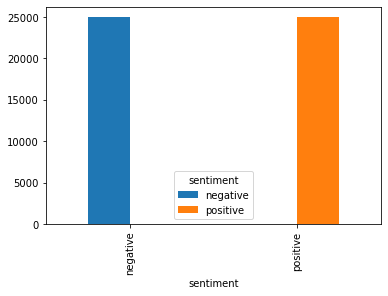

In [4]:
C = ['sentiment']

for i in C:
    ch = pd.crosstab(train[i], train['sentiment'])  
    ch.plot.bar()   
    plt.show() 

In [5]:
labeling = {
    'positive':1, 
    'negative':0
}

train['sentiment'] = train['sentiment'].apply(lambda x : labeling[x])
# Output first ten rows


In [6]:
train.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
5,"Probably my all-time favorite movie, a story o...",1
6,I sure would like to see a resurrection of a u...,1
7,"This show was an amazing, fresh & innovative i...",0
8,Encouraged by the positive comments about this...,0
9,If you like original gut wrenching laughter yo...,1


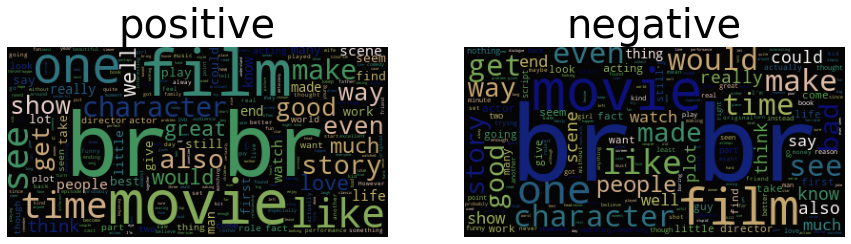

In [7]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
stopword = set(stopwords.words("english"))
subset=train[train.sentiment == 1]
text=subset.review.values
wc= WordCloud(background_color="black",max_words=500,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("positive", fontsize=40)
plt.imshow(wc.recolor(colormap= 'gist_earth'), alpha=0.98)


plt.subplot(122)
subset=train[train.sentiment == 0]
text=subset.review.values
wc= WordCloud(background_color="black",max_words=500,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("negative", fontsize=40)
plt.imshow(wc.recolor(colormap= 'gist_earth'), alpha=0.98)

In [8]:
bert_model_name = 'small_bert/bert_en_uncased_L-8_H-512_A-8'  

tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/2'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/2
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [9]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [10]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [11]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [12]:
classifier_model = build_classifier_model()

In [13]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [14]:
from official.nlp import optimization 
epochs = 5
steps_per_epoch = 625 #tf.data.experimental.cardinality(train_data).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [15]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [16]:
X_train = train["review"]
y_train = train["sentiment"]
X_valid = train["review"]
y_valid = train["sentiment"]

In [17]:
X = train['review']
from sklearn.model_selection import train_test_split
#X_train,X_test,y_train,y_test = train_test_split(data.review,data.sentiment,random_state = 0 , stratify = data.sentiment)

#valid_size=5000
#X_valid, y_valid = X_train[-valid_size:], y_train[-valid_size:]
#X_test, y_test = X_train[:-valid_size], y_train[:-valid_size]
X_train, X_test, y_train, y_test = train_test_split(train.review,train.sentiment, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.16, random_state=1) # 0.25 x 0.8 = 0.2
#print('Train Set ->', X_train.shape, y_train.shape)
#print('Validation Set ->', X_valid.shape, y_valid.shape)
#print('Test Set ->', X_test.shape, y_test.shape)

print('Number of reviews in the total set : {}'.format(len(X)))
print('Number of reviews in the training set : {}'.format(len(X_train)))
print('Number of reviews in the validation set : {}'.format(len(X_valid)))
print('Number of reviews in the testing set : {}'.format(len(X_test)))

Number of reviews in the total set : 50000
Number of reviews in the training set : 33600
Number of reviews in the validation set : 50000
Number of reviews in the testing set : 10000


In [18]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(X_train, y_train,
                               validation_data=(X_valid, y_valid),
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/2
Epoch 1/5
1050/1050 [==============================] - 439s 407ms/step - loss: 0.4046 - binary_accuracy: 0.8002 - val_loss: 0.2696 - val_binary_accuracy: 0.8728
Epoch 2/5
1050/1050 [==============================] - 432s 412ms/step - loss: 0.2658 - binary_accuracy: 0.8856 - val_loss: 0.2097 - val_binary_accuracy: 0.9195
Epoch 3/5
1050/1050 [==============================] - 432s 412ms/step - loss: 0.1810 - binary_accuracy: 0.9296 - val_loss: 0.1940 - val_binary_accuracy: 0.9321
Epoch 4/5
1050/1050 [==============================] - 429s 408ms/step - loss: 0.1487 - binary_accuracy: 0.9437 - val_loss: 0.1940 - val_binary_accuracy: 0.9321
Epoch 5/5
1050/1050 [==============================] - 430s 409ms/step - loss: 0.1488 - binary_accuracy: 0.9444 - val_loss: 0.1940 - val_binary_accuracy: 0.9321


In [19]:
loss, accuracy = classifier_model.evaluate(X_test, y_test)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

313/313 [==============================] - 42s 134ms/step - loss: 0.3461 - binary_accuracy: 0.8794
Loss: 0.34612759947776794
Accuracy: 0.8794000148773193


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


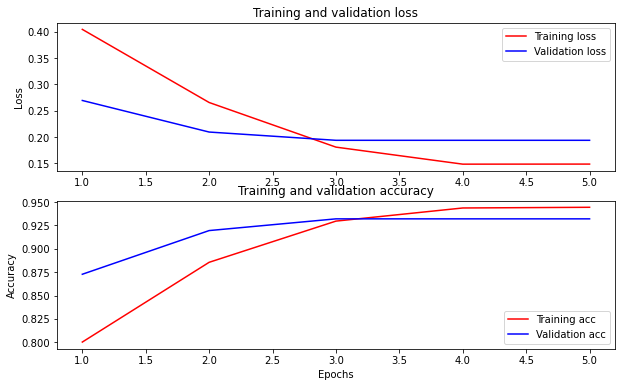

In [20]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')